## Importing Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import Lasso, LinearRegression,Ridge,ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor,AdaBoostRegressor
from sklearn.model_selection import cross_validate

## Dataset Overview

In [2]:
#Import the dataset
dataset = pd.read_csv("housing.csv")

In [3]:
#Display first 5 rows
dataset.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
#Information about columns and datatypes
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Summary of the numerical values
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


In [6]:
# Number of NaN values by column
dataset.isna().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [7]:
# Display the number of duplicated rows.
dataset.duplicated().sum()

0

In [8]:
# Count the numbers of unique values in the categorical column.
dataset.value_counts("ocean_proximity")
# Note that there are only 5 categories. Therefore, it is convenient to use One Hot Encoding method on this column.

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

## Exploratory Data Analysis (EDA)

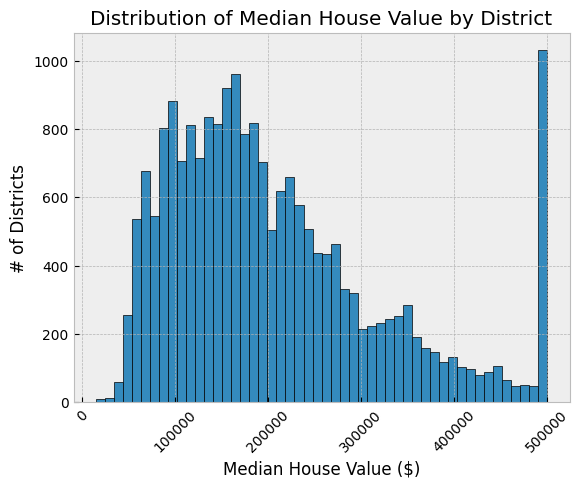

In [41]:
#Distribution of the target variable.
fig, ax = plt.subplots()
ax.hist(
    dataset["median_house_value"], edgecolor="k", bins=50
)
ax.set_title('Distribution of Median House Value by District')
ax.set_xlabel('Median House Value ($)')
ax.set_ylabel('# of Districts')
ax.tick_params(axis = 'x',rotation=45)
plt.show()

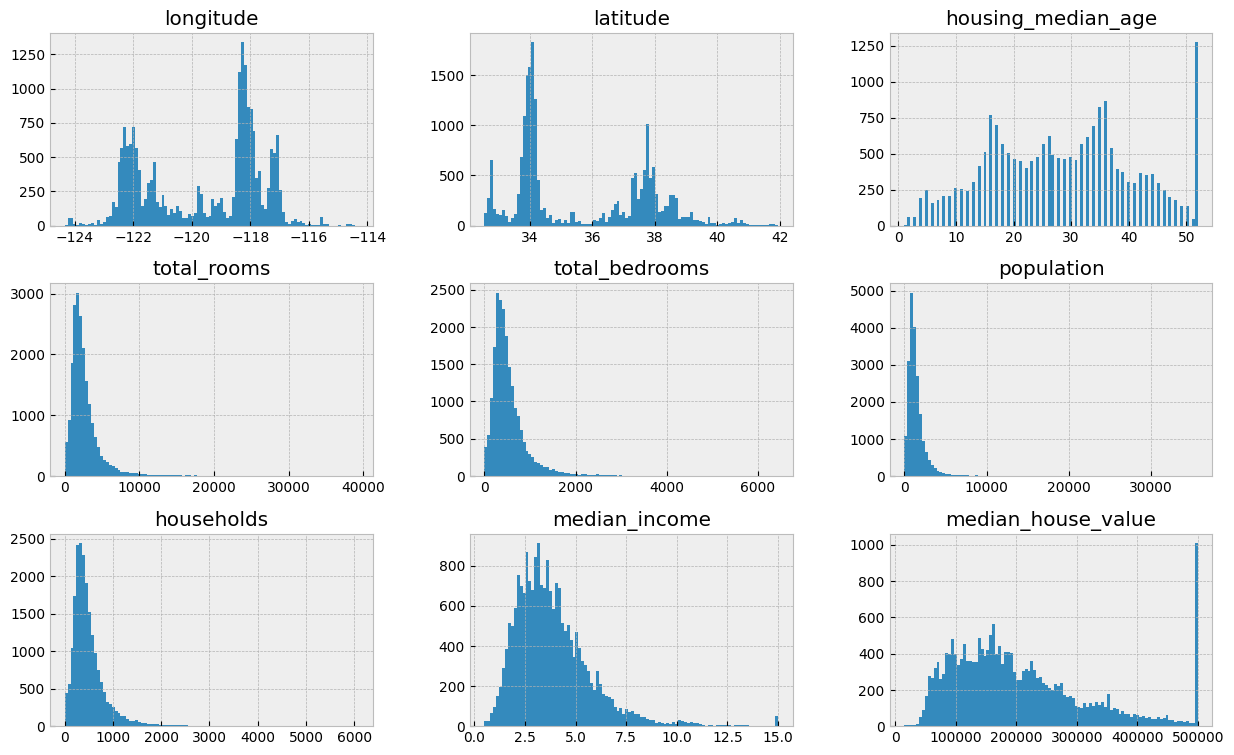

In [10]:
#Distribution of numerical columns.
plt.style.use('bmh')
dataset.hist(bins=100, figsize=(15,9))
plt.show()

C:\Users\Yusuf\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


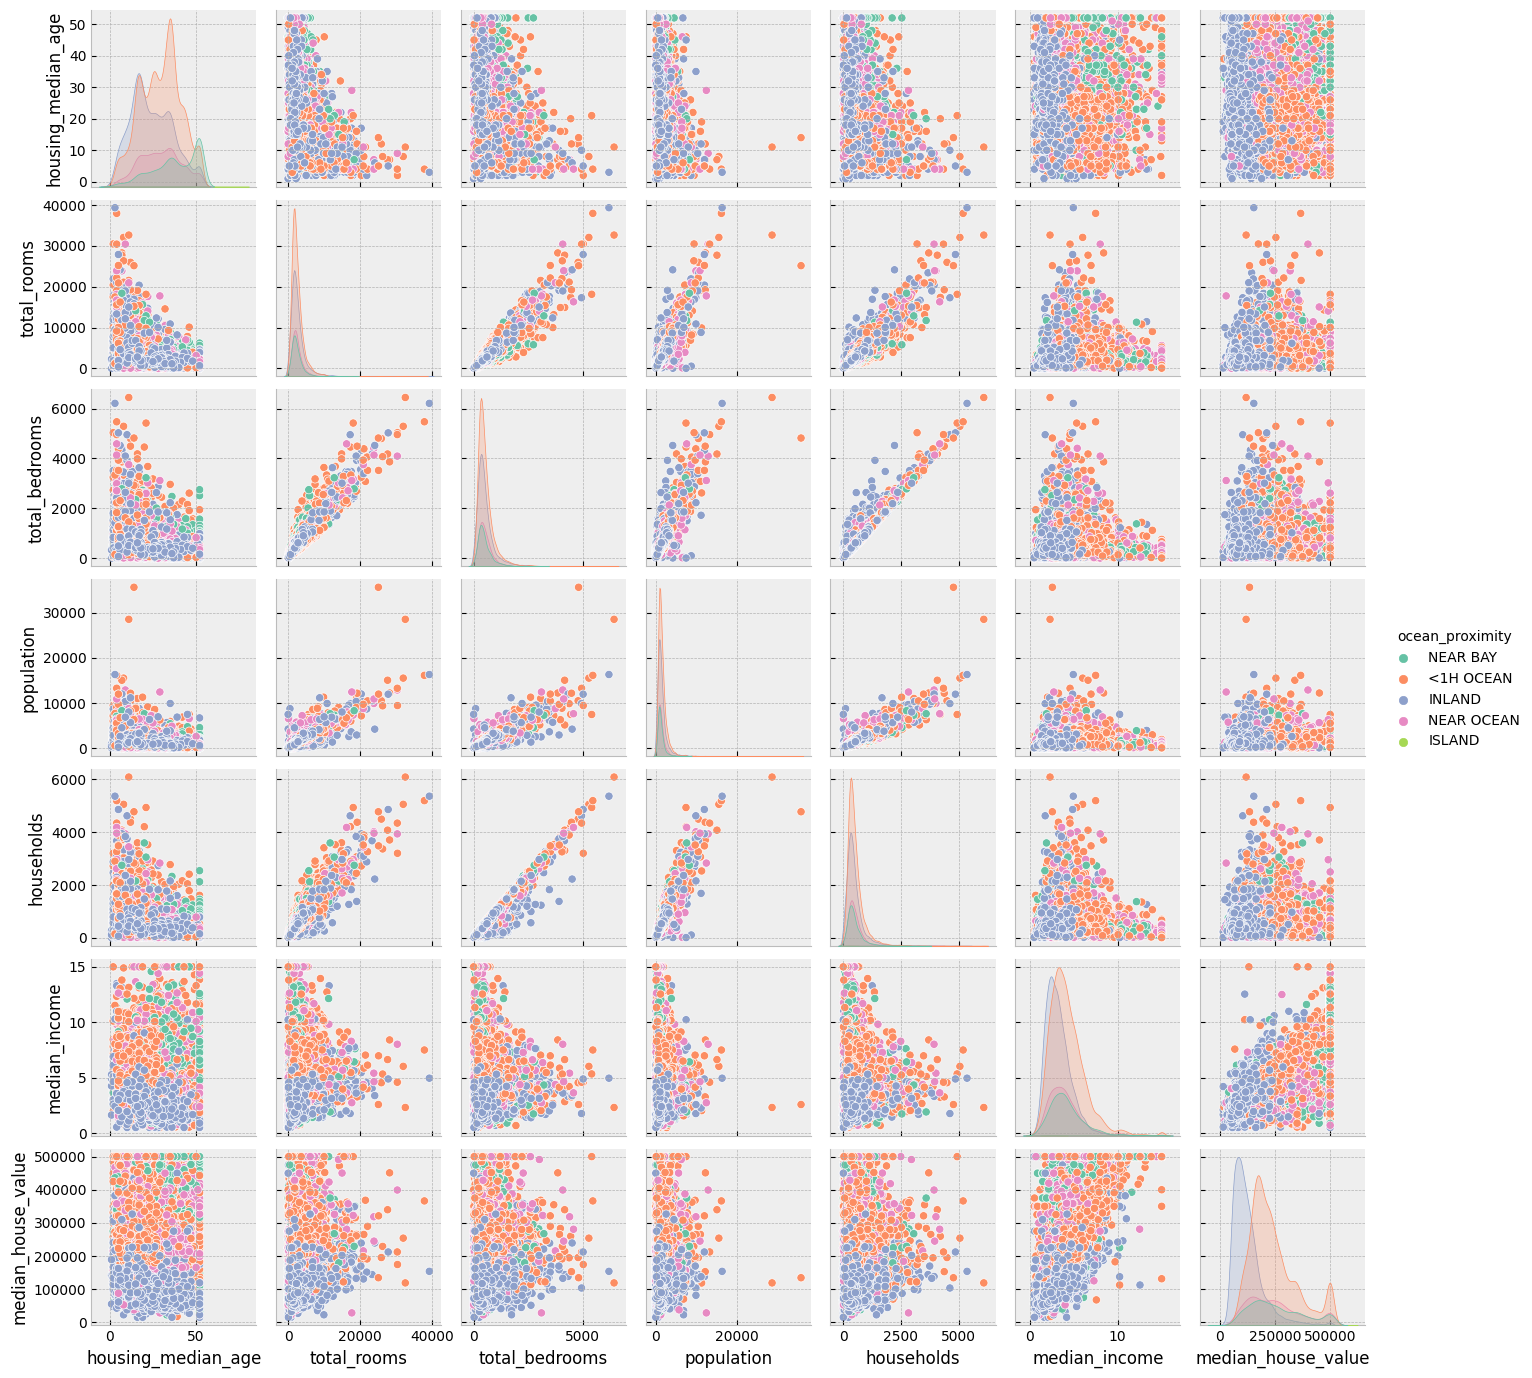

In [11]:
# Draw a pairplot to see the correlation between every 2 numerical variables and the categorical variable.
sns.pairplot(dataset.loc[:,'housing_median_age':'ocean_proximity'],hue = 'ocean_proximity',palette = 'Set2', diag_kind='auto',height = 2)

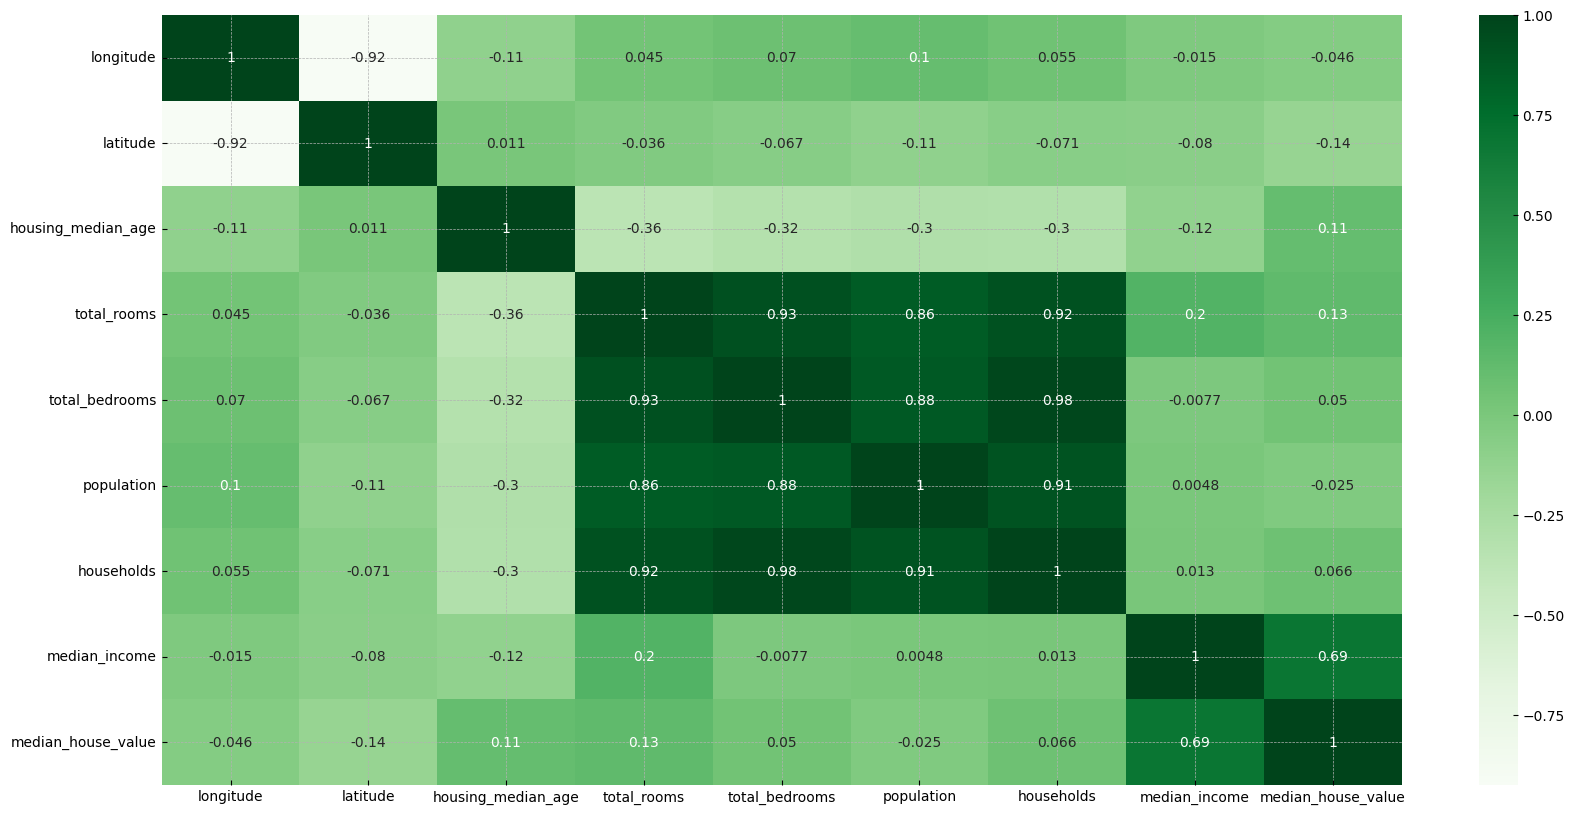

In [47]:
# Dispaly the correlation matrix between numerical variables.
corr = dataset.loc[:,'longitude':'median_house_value'].corr()
plt.figure(figsize=(20,10))
sns.heatmap(corr, cmap="Greens", annot=True);

## Data Pre-Processing

In [13]:
dataset2 = dataset.copy()

### ***Missing Values***

#### Since 'total_bedrooms' values are heavily correlated with other columns, it is convenient to apply Linear Regression to find missing values.

In [14]:
# Apply encoding to categorical values using Panda's "get_dummies" method.
dataset2 = pd.get_dummies(dataset2, columns=["ocean_proximity"])

In [15]:
#Split data set and chech their row numbers.
null_bed = dataset2[dataset2["total_bedrooms"].isna()]
print(null_bed.shape)
notnull_bed = dataset2[dataset2["total_bedrooms"].notna()]
print(notnull_bed.shape)

(207, 14)
(20433, 14)


In [16]:
# Split test and train dataframes as X and y. Note that "test" refers to rows with null values.
test = null_bed
train = notnull_bed

X_train = train.drop("total_bedrooms", axis=1)
X_test = test.drop("total_bedrooms", axis=1)
Y_train = train["total_bedrooms"]
Y_test = test["total_bedrooms"]

In [17]:
#Fit train data.
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

In [18]:
# Assing predictions to 'pred' variable.
pred = model.predict(X_test)

In [19]:
# Predicted 'total_bedrooms' values.
pred

array([ 215.717748  ,  284.36261624, 1288.13618489,  134.73178148,
        157.88460446,  589.30000969,  665.8054133 , 1063.77809288,
        577.7079635 ,  558.94686971,  693.83020611,  387.17583492,
       1361.27739336, 1017.82996105,  618.20399954,  271.38429615,
        311.94405421,  261.10653132,  269.91529729,  754.34110146,
        296.77325796,   90.66757092, -122.58457969,  618.47031346,
        404.88865731, 1041.33769673,  780.67968047,  594.0998112 ,
       1374.10779032,  563.18416574,  788.94260579, 1577.92724076,
       1358.18992812,  426.10949561,  637.53839091,  178.20461413,
        540.67087746,  293.83129323,  331.05080599,  748.90131638,
        421.03847816,  442.21052514,  299.01471878, 1083.67076298,
        669.95909951, 1411.97150496,  446.84549445,  559.8921076 ,
        174.66586373,  311.02566008,  535.95374652,  300.59086042,
        307.63901528,  834.14338945,  271.99856276,  517.05711225,
        300.02019978,  447.55158681,  817.70389111,  471.72557

In [20]:
# Assign predicted values to the null values.
dataset2.loc[dataset2["total_bedrooms"].isna(), "total_bedrooms"] = pred

In [21]:
# Lastly, check all the columns to see if there is any null value left.
dataset2.isna().sum()

longitude                     0
latitude                      0
housing_median_age            0
total_rooms                   0
total_bedrooms                0
population                    0
households                    0
median_income                 0
median_house_value            0
ocean_proximity_<1H OCEAN     0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

In [22]:
# Set the categorical column back using original dataset and drop encoded columns.
dataset2["ocean_proximity"] = dataset["ocean_proximity"]
dataset2.drop(columns = dataset2.select_dtypes(include = bool).columns.tolist(),axis = 1,inplace = True)
dataset2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Outliers

In [23]:
# Numerical description of the dataset.
dataset2.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.35000,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.54000,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.00000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.00000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20640.0,537.913320,421.141737,-122.58458,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.00000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.00000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.49990,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.00000,119600.0000,179700.0000,264725.00000,500001.0000


- As can be seen clearly by looking at histograms on the EDA section, there are some values in 'housing_median_age' and 'median_house_value' columns that doesn't seem realistic.
- Since both of the columns are not correlated with other columns in any way, it is not wise to predict the values using ML algorithms.

In [24]:
# Display the number of outliers.
outlier = (dataset['housing_median_age'] != 52) & (dataset['median_house_value'] != 500001)
print(f"Total number of rows with outliers due to human error:  {np.abs(dataset[outlier].shape[0]-dataset.shape[0])}")
print(f"TOtal number of rows: {dataset.shape[0]}")

Total number of rows with outliers due to human error:  2068
TOtal number of rows: 20640


- Decided to drop these rows for the sake of the accuracy of ML algorithms that will be used.

In [25]:
# Drop misleading rows.
dataset_outliers_dropped = dataset2.loc[outlier,:]

In [26]:
#Number of rows left in the dataset.
dataset_outliers_dropped.shape[0]

18572

### Calculating Z-Score Values

In [27]:
# Create a DataFrame to store Z-scores.
df_z = pd.DataFrame()

In [28]:
# Define a function for adding z-scores to 'df_z' DataFrame by column.
def z_values(df,col,df_z):
    df_z[col] = zscore(df[col],axis = 0)

In [29]:
# Iterate over nunerical columns and apply the function.
for col in dataset_outliers_dropped.select_dtypes(include = 'float64').columns.values.tolist():
    z_values(dataset_outliers_dropped,col,df_z)

In [30]:
# Z-scores overview.
df_z.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,18572.0,-7.015137e-15,1.000027,-2.430858,-1.042538,0.522478,0.764802,2.612530
latitude,18572.0,-9.304544e-16,1.000027,-1.421659,-0.779097,-0.630097,0.966994,2.959867
housing_median_age,18572.0,9.182116e-17,1.000027,-2.273003,-0.873362,0.001413,0.788711,2.100874
total_rooms,18572.0,-9.105598e-17,1.000027,-1.199243,-0.545961,-0.236913,0.231660,16.481543
total_bedrooms,18572.0,-1.224282e-17,1.000027,-1.272503,-0.578062,-0.247154,0.258530,13.741874
population,18572.0,3.672846e-17,1.000027,-1.261825,-0.567018,-0.229934,0.267094,29.418888
households,18572.0,6.121411e-18,1.000027,-1.300764,-0.576864,-0.238018,0.270252,14.306717
median_income,18572.0,3.244348e-16,1.000027,-2.033985,-0.736296,-0.143256,0.587794,7.201796
median_house_value,18572.0,6.121411e-17,1.000027,-1.822872,-0.774709,-0.192171,0.559753,3.240422


In [31]:
# Display the numbers of z-score values over 3 by column.
df_z[df_z > 3 ].notnull().sum()


longitude               0
latitude                0
housing_median_age      0
total_rooms           337
total_bedrooms        337
population            303
households            331
median_income         139
median_house_value    105
dtype: int64

- Since the first 4 columns that contain outliers are not median values but total values, it is understandable to them having a z-score over 3. 
- Further  practice is needed for the last 2 columns, 'median_income' and 'median_house_value'.

In [32]:
# Display the number of rows that have a z-score value exceeding 3.
z_outliers = df_z[(df_z['median_income'] > 3) | (df_z['median_house_value'] > 3 )]
z_outliers.shape[0]

229

In [33]:
# Assign the max. z-score value to the outliers.
df_z.loc[df_z['median_income'] > 3,:] = 3
df_z.loc[df_z['median_house_value'] > 3,:] = 3

In [34]:
# Append the categorical column to the dataframe back.
df_z['ocean_proximity'] = dataset_outliers_dropped['ocean_proximity'] 

- Since we will train models on z-score values, there is no need to standardize or scale values again.

## Encoding

In [35]:
# Apply encoding to categorical values using Panda's "get_dummies" method.
df_z = pd.get_dummies(df_z, columns=["ocean_proximity"])

## Model Selection

In [36]:
# Split the dataset into independent variables and the target valuable.
X = df_z.drop('median_house_value', axis = 1)
y = df_z['median_house_value']

In [37]:
#Display the row and column numbers of X and y.
print(X.shape,y.shape)

(18572, 13) (18572,)


In [38]:
# Models to evaluate.
models = {
'Ridge': {
'model': Ridge(random_state = 99)
},
'ElasticNet': {
'model': ElasticNet(random_state = 99)
},
'KNeighborsRegressor': {
'model': KNeighborsRegressor()
},
'RandomForestRegressor': {
'model': RandomForestRegressor(random_state = 99)
},
'GradientBoostingRegressor': {
'model': GradientBoostingRegressor(random_state = 99)
},
'AdaBoostRegressor': {
'model': AdaBoostRegressor(n_estimators = 5, learning_rate = 1.2, loss = 'exponential', random_state = 99)
}}

In [39]:
# Cross validate every model to prevent overfitting.
for name, dic in models.items():
    for k,model in dic.items():
        cv_results = cross_validate(model, X, y, cv=5, scoring=['r2'])
        print(f'########## {name} ##########')
        print(f'R2: {round(cv_results["test_r2"].mean(),4)}')

########## Ridge ##########
R2: 0.5491
########## ElasticNet ##########
R2: 0.0533
########## KNeighborsRegressor ##########
R2: 0.516
########## RandomForestRegressor ##########
R2: 0.5418
########## GradientBoostingRegressor ##########
R2: 0.6116
########## AdaBoostRegressor ##########
R2: 0.4571


## ***The best performing model is Gradient Boost Regressor with an R2 score of '0.61'***